In [207]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [208]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");

In [209]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [210]:
chemical_family = "Other Compounds"

if chemical_family == "linear alkanes"
    contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
    processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), pcp_source_params) 
    processed_data = sort(processed_data_lin_alkanes, :Mw)
else
    processed_data = filter(row -> lowercase(row.family) == lowercase(chemical_family), pcp_source_params) 
    processed_data = sort(processed_data, :Mw)
end

processed_data.isomeric_SMILES;

In [211]:
alkane_isomeric_smiles = processed_data[!,:isomeric_SMILES]

fingerprints = []

for i in alkane_isomeric_smiles
    fingerprint_spec_i = []

    mol = get_mol(i)
    
    # fp_str1 = get_rdkit_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
    # fp_str2 = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
    # fp_str = fp_str1*fp_str2

    fp_str = get_atom_pair_fp(mol)
    # fp_str = get_pattern_fp(mol)
    
    append!(fingerprint_spec_i, [parse(Float64, string(c)) for c in fp_str])

    desc = get_descriptors(mol)
    relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]

    relevant_desc = [desc[k] for k in relevant_keys]
    append!(fingerprint_spec_i, relevant_desc)
    append!(fingerprints, [fingerprint_spec_i])

end

In [212]:
for num = [0, 1]
    num_cols = length(fingerprints[1])
    zero_cols = trues(num_cols)
    for vec in fingerprints
        zero_cols .&= (vec .== num)
    end
    keep_cols = .!zero_cols # Create a Mask
    fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
end

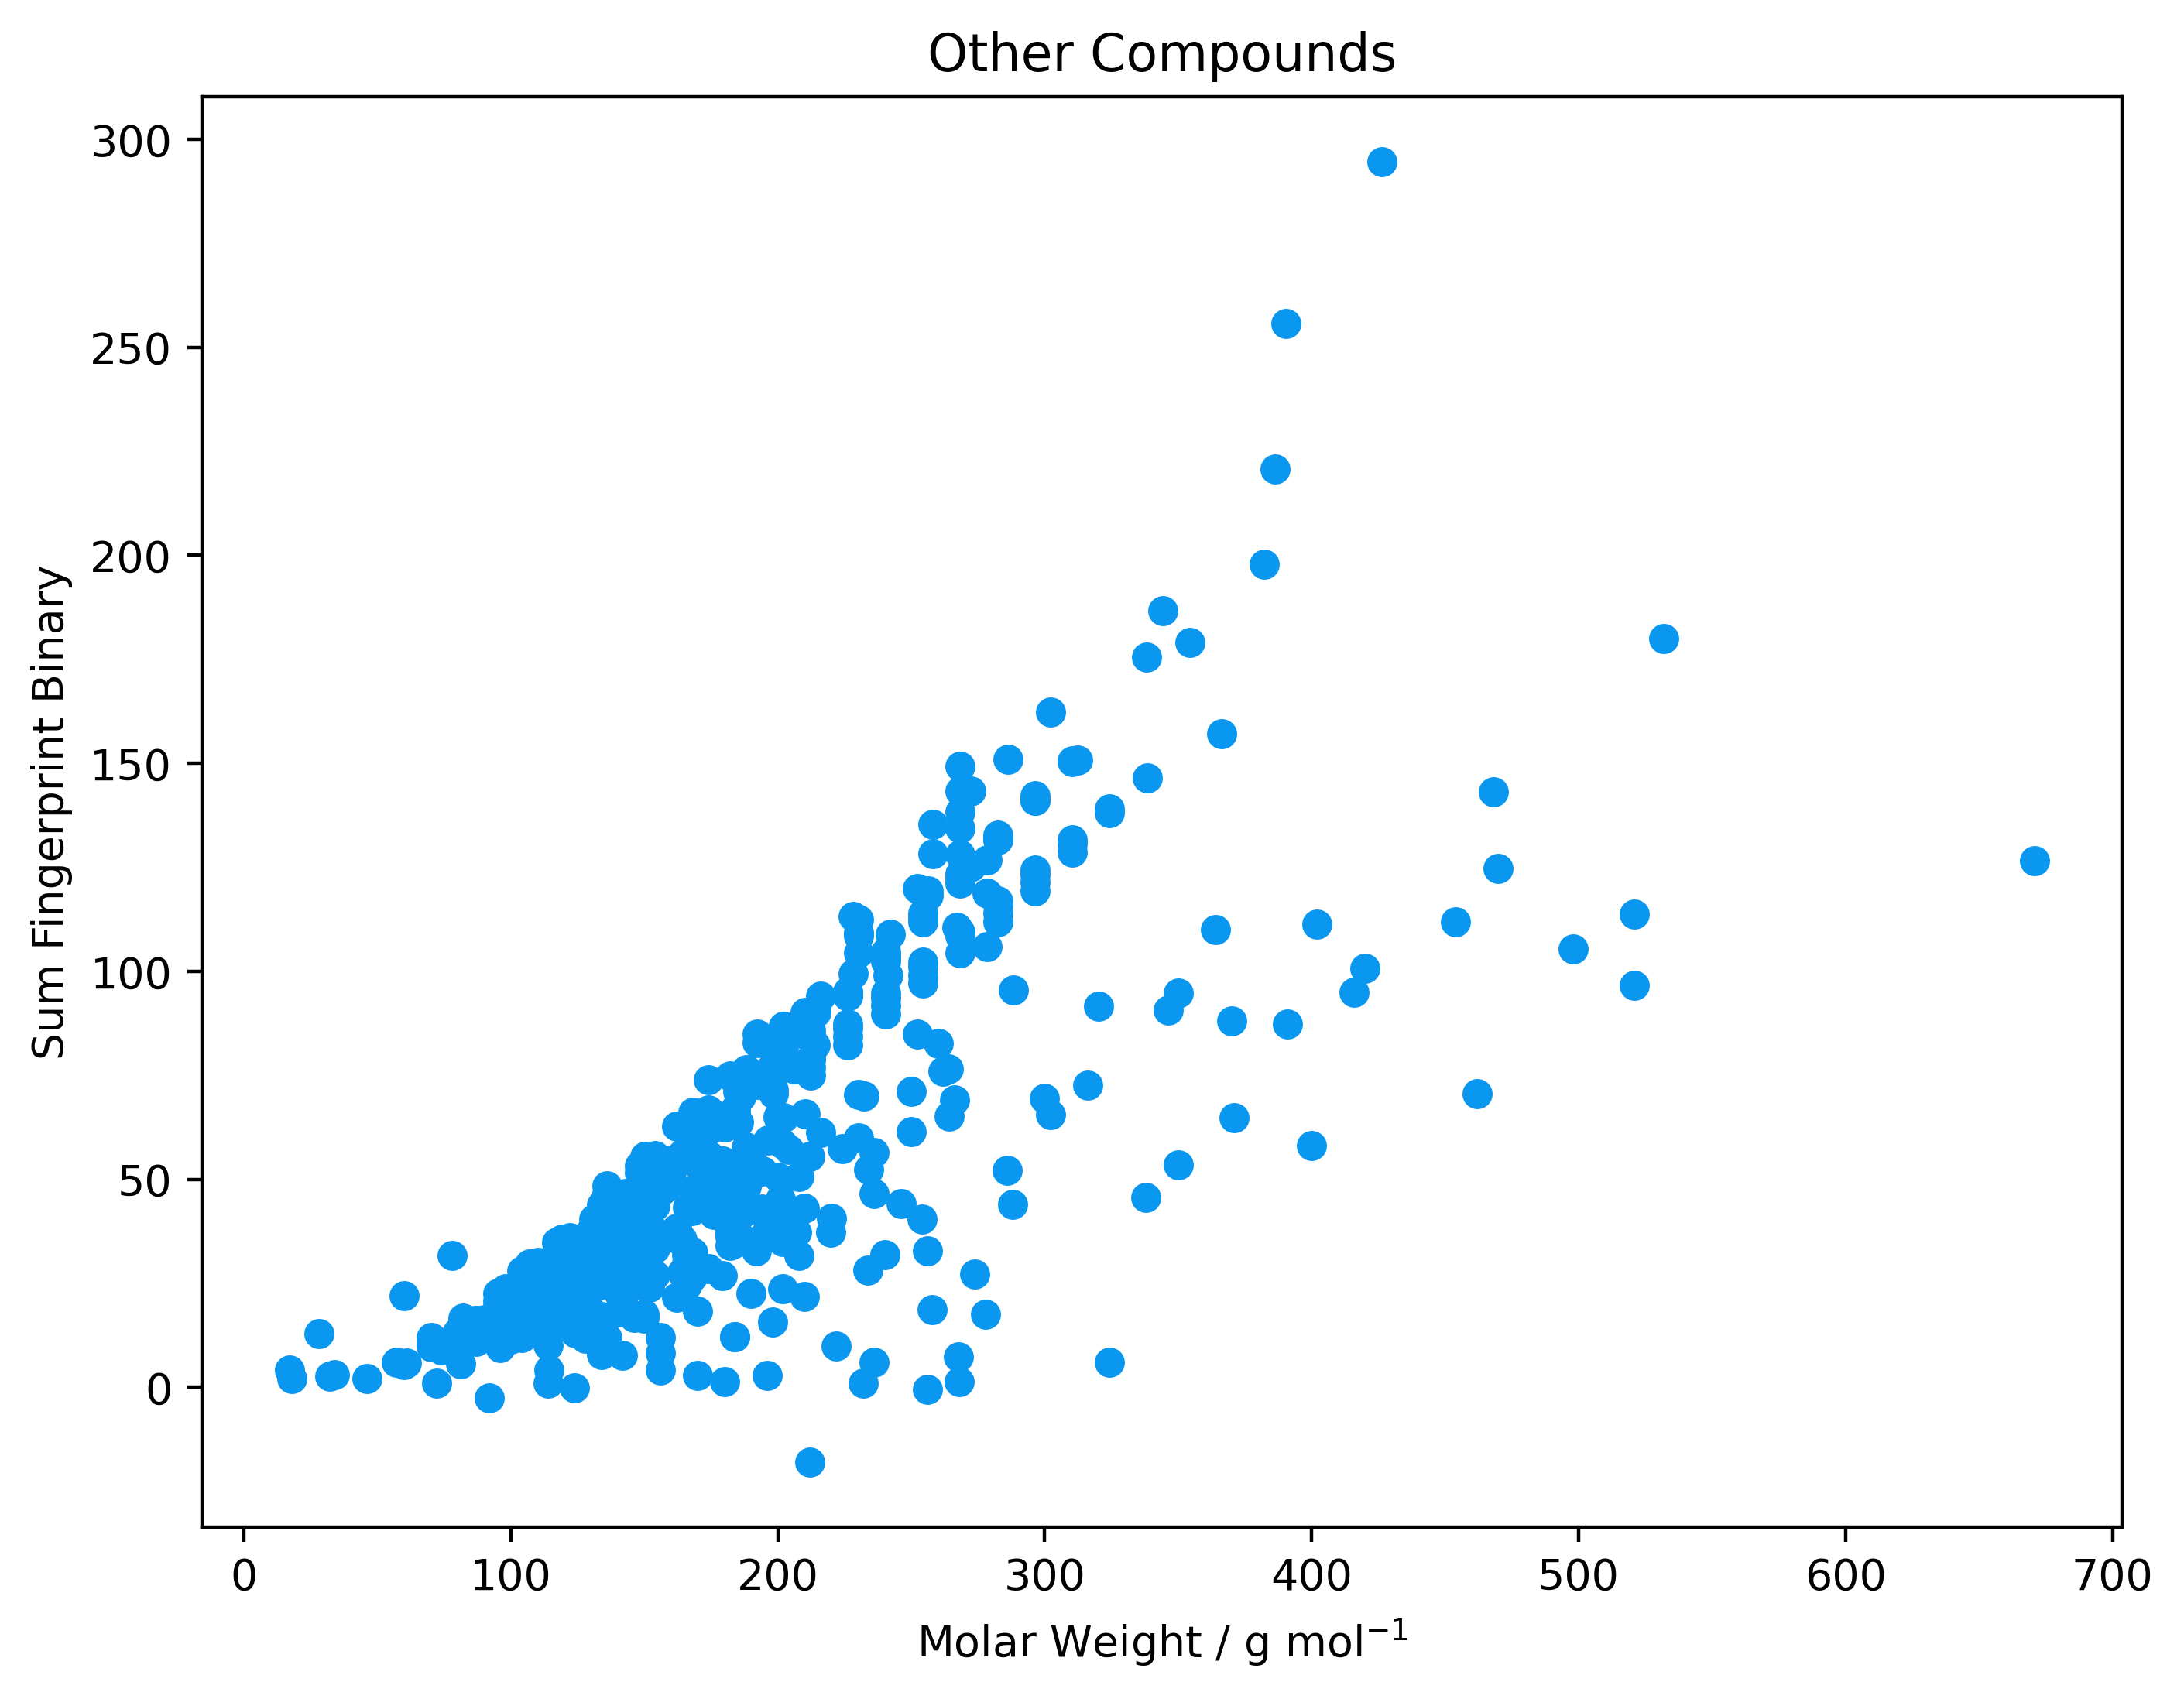

In [213]:
sum_elements = []

for i in fingerprints
    push!(sum_elements, sum(i[1:end-3]))
end

plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(processed_data.Mw, sum_elements,color="#0a97f0")
plt.xlabel("Molar Weight / g mol\$^{-1}\$")
plt.ylabel("Sum Fingerprint Binary")
plt.title(chemical_family);
# plt.xlim([0, 500]);

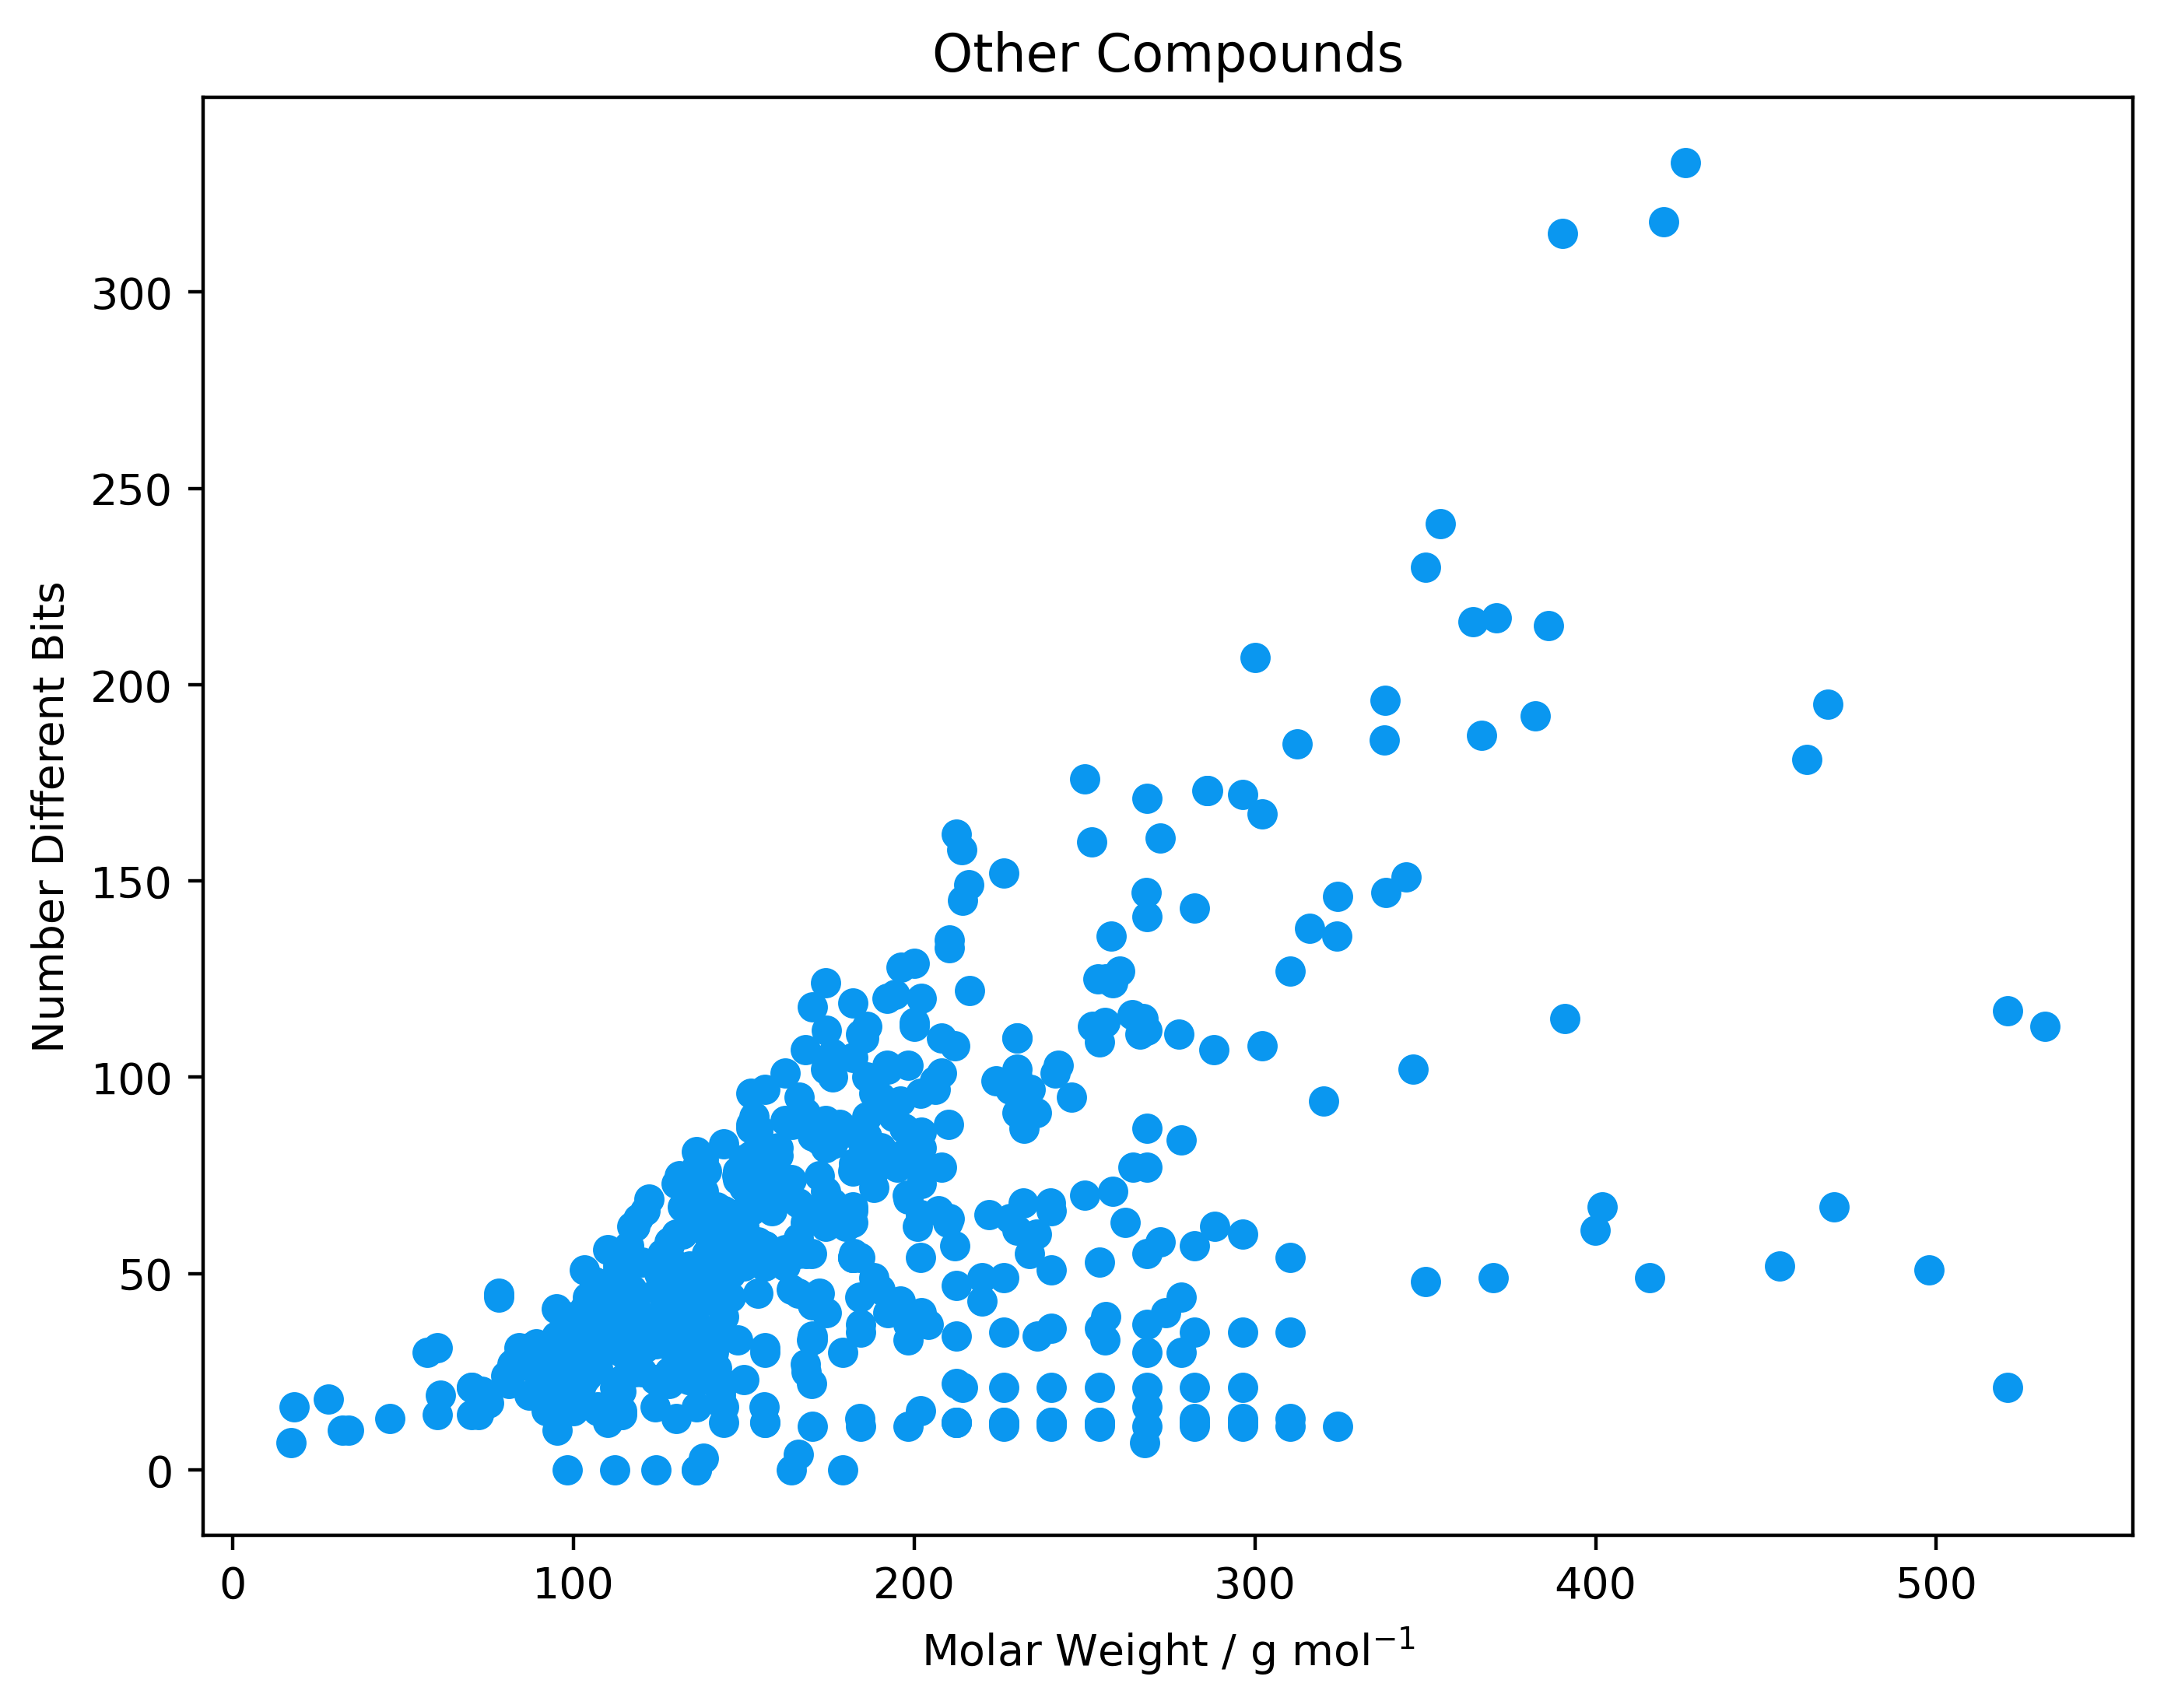

In [214]:
x = []

for molecule = 1:length(fingerprints)-1
    num_in_common = 0

    # For a given chemical family, check how many bits differ between adjacent species (when ordered by increasing Mw)
    for i = 1:length(fingerprints[1])
        if fingerprints[molecule][i] ≠ fingerprints[molecule+1][i]
            num_in_common += 1
        end
    end
    push!(x, (molecule, num_in_common))
end

plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(processed_data.Mw[1:end-1], last.(x),color="#0a97f0")
plt.ylabel("Number Different Bits")
plt.xlabel("Molar Weight / g mol\$^{-1}\$");
plt.title(chemical_family);

In [215]:
unique_values = unique(pcp_source_params[!, :family])
num_families = length(unique_values)
println(unique_values)

String31["Alkanes", "Inorganic compounds", "Other compounds", "Alkynes", "Nitriles", "Elements", "Alkenes", "Aldehydes", "Amines", "Silanes/siloxanes", "Alcohols", "Fluorides", "Cyclic compounds", "Acids", "Ethers", "Thiols", "Chlorides", "Ketones", "Polyfunctional compounds", "Sulfides/thiophenes", "Esters", "Aromatic hydrocarbons", "Halogenated compounds"]


In [216]:


# for i in unique_values
#     println(i)
#     filtered_data_chem_family = filter(row -> row.family == i, pcp_source_params) ;
#     filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
#     isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]
#     fingerprints = []

#     for i in isomeric_smiles_family

#         mol = get_mol(i)
#         desc = get_descriptors(mol)
#         relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]
#         relevant_desc = [desc[k] for k in relevant_keys]

        fingerprint_spec_i_rdkit = []
        fingerprint_spec_i_morgan = []
        fingerprint_spec_i_atom_pair = []
        fingerprint_spec_i_pattern = []
        
        fp_str_rdkit = get_rdkit_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
        fp_str_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        fp_str_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        fp_str_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        
        append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_rdkit])
        append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_morgan])
        append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_atom_pair])
        append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_pattern])

        append!(fingerprint_spec_i_rdkit, relevant_desc)
        append!(fingerprint_spec_i_morgan, relevant_desc)
        append!(fingerprint_spec_i_atom_pair, relevant_desc)
        append!(fingerprint_spec_i_pattern, relevant_desc)

#         # grouped_fp = [fingerprint_spec_i_rdkit, fingerprint_spec_i_morgan, fingerprint_spec_i_atom_pair, fingerprint_spec_i_pattern]
#         append!(fingerprints, [fingerprint_spec_i_rdkit])

#     end

#     for num = [0, 1]
#         num_cols = length(fingerprints[1])
#         zero_cols = trues(num_cols)
#         for vec in fingerprints
#             zero_cols .&= (vec .== num)
#         end
#         keep_cols = .!zero_cols # Create a Mask
#         fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
#     end

#     # println(fingerprints)

#     x = []
#     for molecule = 1:length(fingerprints)-1
#         num_in_common = 0

#         # For a given chemical family, check how many bits differ between adjacent species (when ordered by increasing Mw)
#         for i = 1:length(fingerprints[1])
#             if fingerprints[molecule][i] ≠ fingerprints[molecule+1][i]
#                 num_in_common += 1
#             end
#         end
    
#         push!(x, (molecule, num_in_common))
#     end

# end

# println(fingerprints[1])
# @show length(fingerprints[1])

In [233]:
minima = []

for i in unique_values
    println(i)
    filtered_data_chem_family = filter(row -> row.family == i, pcp_source_params) ;
    filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
    isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]

    fingerprints_rdkit = []
    fingerprints_morgan = []
    fingerprints_atom_pair = []
    fingerprints_pattern = []

    for i in isomeric_smiles_family

        fingerprint_spec_i_rdkit = []
        fingerprint_spec_i_morgan = []
        fingerprint_spec_i_atom_pair = []
        fingerprint_spec_i_pattern = []

        mol = get_mol(i)
        desc = get_descriptors(mol)
        relevant_keys = ["CrippenClogP", "amw", "FractionCSP3"]
        relevant_desc = [desc[k] for k in relevant_keys]

        fp_str_rdkit = get_rdkit_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
        fp_str_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        fp_str_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        fp_str_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        
        append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_rdkit])
        append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_morgan])
        append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_atom_pair])
        append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_pattern])

        append!(fingerprint_spec_i_rdkit, relevant_desc)
        append!(fingerprint_spec_i_morgan, relevant_desc)
        append!(fingerprint_spec_i_atom_pair, relevant_desc)
        append!(fingerprint_spec_i_pattern, relevant_desc)

        append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
        append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
        append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])
        append!(fingerprints_pattern, [fingerprint_spec_i_pattern])






        fingerprint_spec_i = []

        mol = get_mol(i)
        
        # fp_str1 = get_rdkit_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
        # fp_str2 = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        # fp_str = fp_str1*fp_str2

        fp_str = get_atom_pair_fp(mol)
        # fp_str = get_pattern_fp(mol)
        
        append!(fingerprint_spec_i, [parse(Float64, string(c)) for c in fp_str])

        desc = get_descriptors(mol)
        relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]

        relevant_desc = [desc[k] for k in relevant_keys]
        append!(fingerprint_spec_i, relevant_desc)
        append!(fingerprints, [fingerprint_spec_i])

    end


    for num = [0, 1]
        num_cols = length(fingerprints[1])
        zero_cols = trues(num_cols)
        for vec in fingerprints
            zero_cols .&= (vec .== num)
        end
        keep_cols = .!zero_cols # Create a Mask
        fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
    end

    num_diff_for_adjacent_spec_in_fam = []
    for molecule = 1:length(fingerprints)-1
        num_different = 0

        # For a given chemical family, check how many bits differ between adjacent species (when ordered by increasing Mw)
        for i = 1:length(fingerprints[1])
            if fingerprints[molecule][i] ≠ fingerprints[molecule+1][i]
                num_different += 1
            end
        end

        push!(num_diff_for_adjacent_spec_in_fam, num_different)
    end
    push!(minima, minimum(num_diff_for_adjacent_spec_in_fam))
end

plt.scatter(unique_values, minima)
plt.ylabel("Minimum Number Different Bits")
plt.xticks(rotation=45,ha="right");
# plt.ylim([0, 20])


Alkanes
Inorganic compounds
Other compounds
Alkynes
Nitriles
Elements
Alkenes
Aldehydes
Amines
Silanes/siloxanes
Alcohols
Fluorides
Cyclic compounds
Acids
Ethers
Thiols
Chlorides
Ketones
Polyfunctional compounds
Sulfides/thiophenes
Esters
Aromatic hydrocarbons
Halogenated compounds


LoadError: UndefVarError: `ymin` not defined